# MSDM5056 Tutorial 7 - Network Models II

## Contents

1. The Watts-Strogatz Model
2. The Newman-Watts Model
3. Small-World Routing

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

Real networks possess three features:

1. a scale-free degree distribution $P_k$,
2. a high average clustering coefficient $C$
3. a short average shortest path length $L$.

In terms of social networks, the three features corresponds to three observations.

1. Most people are anonymous, whereas a few are very famous.
2. My friends' friends are usually my friends.
3. We are connected via a strikingly small number of interpersonal connections.

Small-world networks are networks that possess a high $C$ and a short $L$ but lack a scale-free $P_k$. Hence "small-world networks" is actually a misnomer because random networks also show the small-world phenomenon $L\sim\ln{N}$. What truly sets small-world networks apart from random ones is their exceptionally high $C$.

---

# 1. The Watts-Strogatz Model

While social scientists have long noticed that our worlds are small [1], no one could systematically explain its origin until Watts and Strogatz proposed their pioneering network model in 1998 [2]. 

## 1.1 Algorithm

The Watts-Strogatz (WS) model parametrizes a network with 

- number of nodes $N$, 
- an average degree $K$, which should be an even number
- a rewiring probability $p$

The construction procedures follows:

1. Starting with a $K$-regular ring, i.e. a ring lattice with each node additionally connected to its nearest ($K-2$) neighbors. 
2. For each node $i$, rewires the $\dfrac{K}{2}$ edges on its right with a probability $p$
3. To avoid self-loops or multi-edges, the edges cannot be rewired to nodes that are already connected to $i$. But it is allowed to rewir水 to the same node the edge originally connected to.  

You can construct a WS network with `watts_strogatz_graph()`. We often impose constraints $N\gg K\gg\ln{N}\gg1$ so that the resultant WS network behaves desirably: while staying connected, it will not be as dense as a complete network.

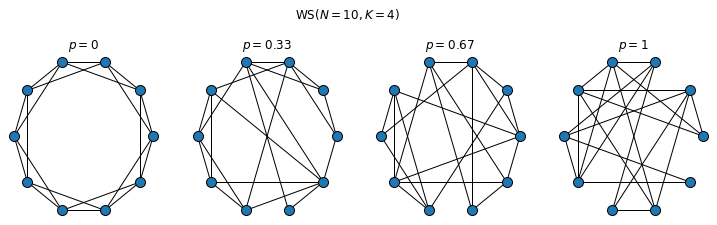

In [3]:
ws = nx.watts_strogatz_graph

N,K = 10,4
fig,ax = plt.subplots(1,4, figsize=(3*4+.2*3,3))
fig.suptitle(r'$\mathrm{WS}{\left(N=%d, K=%d\right)}$' % (N,K), y=1.1)
for i,a in enumerate(ax):
    nx.draw_circular(ws(N, K, i/3, seed=5056+i), ax=a, node_size=100, edgecolors='k')
    a.set_title(r'$p=%.2g$' % (i/3))

Here comes an interesting point regarding the WS model

- At $p=0$, a WS network is simply a $K$-regular ring. 
- But as it grows to $p=1$, it becomes more disordered and becomes a random network. 

We know that a regular ring is highly clustered with a large internodal separation, whereas a random network is lowly clustered with a small internodal separation — how does a WS network's $C$ and $L$ evolves with $p$ then?

## 1.2 Properties

### 1.2.1. Degree distribution

A WS network does not show a scale-free but a bell-shaped $P(k)$, whose width grows with $p$. 

- At $p=0$, $P(k) = \delta{\left(k-K\right)}$ (the Dirac delta function), same as regular lattice. 
- As $p$ grows, $P(k)$ gets gradually broadened, and it becomes the widest when $p=1$. 

Although a WS network is completely random at $p=1$, notice that $P^{\left(p=1\right)}(k)$ is not identical to that of an ER network with $\langle{k}\rangle=K$ because of their different algorithms. Their biggest difference lies upon the fact that all nodes in a WS network are guaranteed to have at least $\dfrac{K}{2}$ edges even after the network is completely rewired. In fact, $P(k)$ reads [3]

\begin{align*}
    P(k) = \sum_{n=0}^{\min{\left(k-\frac{K}{2},\frac{K}{2}\right)}} {
          \left(\matrix{\frac{K}{2}\\n}\right)(1-p)^n p^{\frac{K}{2}-n}
          \dfrac{\left(\frac{pK}{2}\right)^{k-\frac{K}{2}-n}}
                {\left(k-\frac{K}{2}-n\right)!} e^{-\frac{pK}{2}} }
\end{align*}

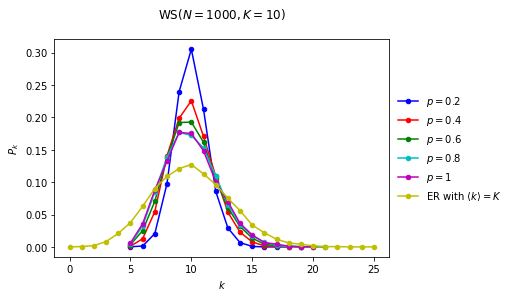

In [3]:
def add_list(list1, list2):
    sum_ = [a+b for a,b in zip(list1,list2)]
    return sum_+list1[len(sum_):]+list2[len(sum_):]
def add_list_of_lists(list_of_lists):
    sum_ = list_of_lists[0]
    for list_ in list_of_lists[1:]:
        sum_ = add_list(sum_, list_)
    return sum_
er = nx.erdos_renyi_graph

N,K = 1000,10
ps = [.2,.4,.6,.8,1,'ER']
trials = 10
for i,p in enumerate(ps):
    if p == 'ER':
        hists = [nx.degree_histogram(er(N,K/(N-1),5056+trials*i+t))for t in range(trials)]
    else:
        hists = [nx.degree_histogram(ws(N,K,p,5056+trials*i+t))for t in range(trials)]
    hist = add_list_of_lists(hists)
    kMin = np.argmax(np.array(hist)>0)
    plt.plot(range(kMin,len(hist)), [h/N/trials for h in hist[kMin:]],
             '.-'+['b','r','g','c','m','y'][i], ms=9,
             label= r'ER with $\langle{k}\rangle=K$' if p=='ER' else r'$p=%g$'%p)
plt.legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
plt.title(r'$\mathrm{WS}{\left(N=%d, K=%d\right)}$'%(N,K)+'\n')
plt.xlabel('$k$')
plt.ylabel('$P_k$')
plt.show()

### 1.2.2. Clustering coefficient

A $K$-regular ring has $C{\left(0\right)} = \dfrac{3\left(K-2\right)}{4\left(K-1\right)}$. Because each edge is rewired with a probability $p$, triangles in the ring remain connected with a probability $\left(1-p\right)^3$. This gives us a rough estimate of $C{\left(p\right)}$:

\begin{align*}
    C{\left(p\right)} \approx \dfrac{3\left(K-2\right)}{4\left(K-1\right)} \left(1-p\right)^3\,.
\end{align*}

This estimation is not exact and particularly deviates at a large $p$ because it has ignored the new triangles formed after rewiring. The probability of new triangles however vanishes if $N\gg K$.

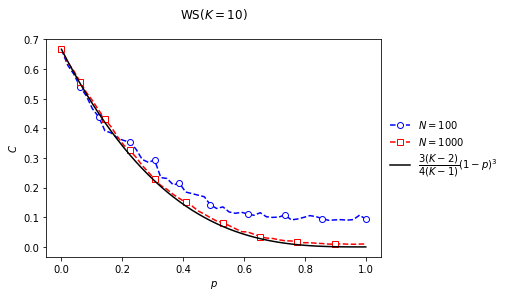

In [4]:
N1,N2,K = 100,1000,10
ps = np.linspace(0,1)
plt.plot(ps, [nx.average_clustering(ws(N1,K,p,5056)) for p in ps],
         'bo--', mfc='w', markevery=.1, label='$N=%d$'%N1)
plt.plot(ps, [nx.average_clustering(ws(N2,K,p,5056)) for p in ps],
         'rs--', mfc='w', markevery=.1, label='$N=%d$'%N2)
plt.plot(ps, .75*(K-2)/(K-1)*(1-ps)**3, 'k',
         label=r'$\dfrac{3\left(K-2\right)}{4\left(K-1\right)}\left(1-p\right)^3$')
plt.title(r'$\mathrm{WS}{\left(K=%d\right)}$'%K+'\n')
plt.xlabel('$p$')
plt.ylabel('$C$')
plt.legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
plt.show()

### 1.2.3. Shortest path length

When $p$ is closed to $0$, a WS network possesses $L{\left(0^+\right)}\approx\dfrac{N}{2K}\sim N$. On the other hand, when $p$ grows to approach $1$, the small-world property emerges in the WS network, i.e. $L{\left(1^-\right)}\approx\dfrac{\ln{N}}{\ln{K}}\sim\ln{N}$. However, so far we cannot analytically describe this drop in $L\left(p\right)$.

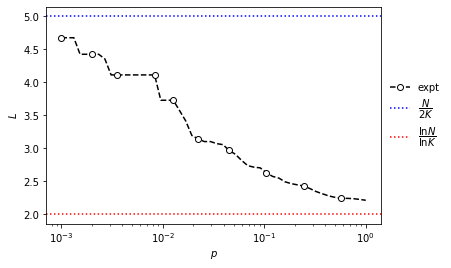

In [5]:
N,K = 100,10
ps = np.logspace(-3,0)
plt.plot(ps, [nx.floyd_warshall_numpy(ws(N,K,p,5056)).sum()/(N*(N-1))
              for p in ps], 'ko--', mfc='w', markevery=.1, label='expt')
plt.axhline(N/(2*K), c='b', ls=':', label=r'$\dfrac{N}{2K}$')
plt.axhline(np.log(N)/np.log(K), c='r', ls=':', label=r'$\dfrac{\ln{N}}{\ln{K}}$')
plt.legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
plt.xlabel('$p$')
plt.ylabel('$L$')
plt.xscale('log')
plt.show()

## 1.3 Physics of the clustered small world

If you scan $p$ carefully, you will see that for a range of small $p$, the resultant WS network strikingly possesses both a high $C$ and a short $L$. The WS model thus marks a milestone of network science—scientists can finally reason the coexistence of clustering and small-world effect on real networks.

**<p style="text-align: center">While short-range friendships keeps our world highly clustered,</p>**
**<p style="text-align: center">long-range friendships act as shortcuts to pull us much closer to each other.</p>**

Still, the WS model is not perfect because it fails to yield a scale-free degree distribution and thus to predict celebrities. Anyhow, Watts and Strogatz's inspiring results sparked a wave of researches about small-world phonemona. Their model, along with Barabási and Albert's one, which you will encounter in Lecture 8, have brought network science to a new era.

In [ ]:
# try to locate the regime where a WS network has a high C and a short L

# this is your second lab!

---
# 2. The Newman-Watts Model

Although the Watts-Strogatz model is insightful, it is too tough to analyse this pioneering model's properties. For this reason, Newman and Watts slightly amended it to a mathematically simple model, i.e. the Newman-Watts (NW) model, which adds edges instead of rewiring edges.

## 2.1 Algorithm

As same as the WS model, the NW model specifies three parameters including 

- number of nodes $N$, 
- an initial average degree $K$
- a shortcut probability $p$. 

The construction procedures follows:

1. Starting from a $K$-regular ring, i.e. a ring lattice with each node additionally connected to its nearest ($K-2$) neighbors. 
2. Add a random edge for every edge count in the ring with a probability $p$, i.e. it adds $\dfrac{NK}{2}p$ random edges to the ring on average. 
3. NW model does not prohibit the possibility of self-loops and multi-edges for statistical neatness. 

You can generate a "NW network" with `newman_watts_strogatz_graph()`. The returned network is however somewhat statistically different from Newman and Watts's prescription because the method explicitly bans self-loops and multi-edges. Still, the deviance diminishs as $N\gg K$ infinitely suppresses the probability of their existence.

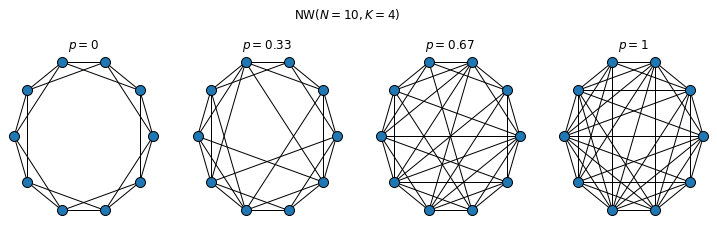

In [4]:
nw = nx.newman_watts_strogatz_graph # statistically inaccurate

N,K = 10,4
fig,ax = plt.subplots(1,4, figsize=(3*4+.2*3,3))
fig.suptitle(r'$\mathrm{NW}{\left(N=%d, K=%d\right)}$' % (N,K), y=1.1)
for i,a in enumerate(ax):
    nx.draw_circular(nw(N, K, i/3, seed=5056+i), ax=a, node_size=100, edgecolors='k')
    a.set_title(r'$p=%.2g$' % (i/3))

## 2.2 Properties

When $p$ is small, the NW model behaves similarly to the WS model. On the other hand, the NW model behaves nicer than the WS model at a large $p$, and its nice behaviours helps us easier derive its characteristic properties.

### 2.2.1. Degree distribution

Since $\dfrac{NK}{2}p$ edges brings $NKp$ ends of edges, every node expects to receive new $pK$ ends of edges, so its degree on average rises to $\langle{k}\rangle=K\left(1+p\right)$. The probability that a node receives exactly $x$ ends follows a Poisson distribution

\begin{align*}
    P(x) = \dfrac{\left(pK\right)^x}{x!} e^{-pK}\,;
\end{align*}

The new degree of the node becomes $k=K+x$. So the NW model's degree distribution reads

\begin{align*}
    P(k) = \dfrac{\left(pK\right)^{\left(k-K\right)}}{\left(k-K\right)!} e^{-pK}\,.
\end{align*}

Due to its algorithm, $k$ is definitely large than or equal to $K$. This parallels the case that $k\geq\dfrac{K}{2}$ on a WS network.

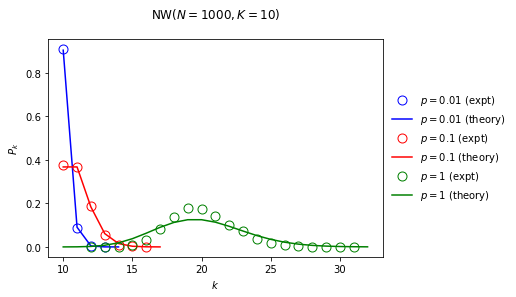

In [7]:
from scipy.special import factorial

N,K = 1000,10
ps = [.01,.1,1]
trials = 10
for i,p in enumerate(ps):
    hist = add_list_of_lists([nx.degree_histogram(nw(N,K,p,5056+trials*i+t))for t in range(trials)])
    kMin = np.argmax(np.array(hist)>0)
    plt.plot(range(kMin,len(hist)), [h/N/trials for h in hist[kMin:]],
             'o'+['b','r','g'][i], ms=9, mfc='none', label= r'$p=%g$ (expt)'%p)
    ks = np.arange(K, len(hist)+1, dtype=float)
    plt.plot(ks, (p*K)**(ks-K)/factorial(ks-K)*np.exp(-p*K),
             '-'+['b','r','g'][i], label=r'$p=%g$ (theory)'%p) 

plt.legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
plt.title(r'$\mathrm{NW}{\left(N=%d, K=%d\right)}$'%(N,K)+'\n')
plt.xlabel('$k$')
plt.ylabel('$P_k$')
plt.show()

### 2.2.2. Transitivity

Recall that a network's transitivity, aka global clustering coefficient $C_\Delta$, is defined as

\begin{align*}
    C_\Delta &= 3\times\dfrac{\text{# triangles}}{\text{# triads}} \\
 &\equiv \dfrac{\mathrm{tr}{\left(\mathbf{A}^3\right)}}
               {\sum_{i\neq j}{\left(\mathbf{A}^2\right)_{ij}}}\,,
\end{align*}

where $A$ denotes the network's adjacency matrix. The quantity measures a network's extent of clustering from a perspective different from the (average local) clustering coefficient $C$. Whereas $C=\langle{c}\rangle$ is an average of ratios, $C_\Delta$ is a ratio of sums. It turns out that instead of its clustering coefficient, we can analytically compute an NW network's transitivity [4].

\begin{align*}
    C_\Delta{\left(p\right)} = \dfrac{3\left(K-2\right)}{4\left(K-1\right)+4Kp\left(p+2\right)}
\end{align*}

$C_\Delta{\left(0\right)}=\dfrac{3\left(K-2\right)}{4\left(K-1\right)}$ equals $C{\left(0\right)}$ of a WS network, whereas $C_\Delta{\left(1\right)}=\dfrac{3\left(K-2\right)}{4\left(4K-1\right)}$.

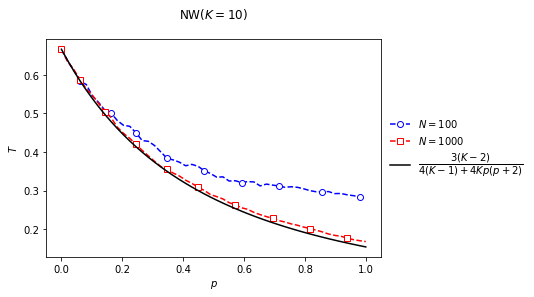

In [8]:
N1,N2,K = 100,1000,10
ps = np.linspace(0,1)
plt.plot(ps, [nx.transitivity(nw(N1,K,p,5056)) for p in ps],
         'bo--', mfc='w', markevery=.1, label='$N=%d$'%N1)
plt.plot(ps, [nx.transitivity(nw(N2,K,p,5056)) for p in ps],
         'rs--', mfc='w', markevery=.1, label='$N=%d$'%N2)
plt.plot(ps, 3*(K-2)/(4*(K-1)+4*K*ps*(ps+2)), 'k',
         label=r'$\dfrac{3\left(K-2\right)}{4\left(K-1\right)+4Kp\left(p+2\right)}$')
plt.legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
plt.title(r'$\mathrm{NW}{\left(K=%d\right)}$'%K+'\n')
plt.xlabel('$p$')
plt.ylabel('$T$')
plt.show()

### 2.2.3. Shortest Path Length.

While $L$ of a WS network is almost analytically intractable (not completely though [6]), we can reasonably approximate that of an NW network. Through a dimensional analysis, Newman and Watts argued that $L$ must obey a universal relation [5]

\begin{align*}
    \dfrac{KL}{N} = f{\left(NKp\right)}\,.
\end{align*}

Experimentally we observe that $L\sim\ln{N}$ when $N\gg K$ and $p\rightarrow1$, so the scaling function $f{\left(x\right)}$ has to be asymptotic to $\dfrac{\ln{x}}{x}$ when $x\rightarrow\infty$. Newman, Moore, and Watts applied a mean-field approach, originating from statistical physics, to derive a formula for $f{\left(x\right)}$ [7]:

\begin{align*}
    f{\left(x\right)} &= \dfrac{2}{\sqrt{x^2+4x}}\,\tanh^{-1}{\sqrt{\dfrac{x}{x+4}}} \\
                      &= \dfrac{1}{\sqrt{x^2+4x}}\,\ln {\dfrac{\sqrt{1+4/x}+1}{\sqrt{1+4/x}-1}},
\end{align*}

which indeed approaches $\dfrac{\ln{x}}{x}$ at a large $x$. The mean-field approximation is accurate when $x=NKp$ is either very large or very small.

In [9]:
def f(x):
    y = (1+4/x)**.5
    return (x**2+4*x)**-.5 * np.log((y+1)/(y-1))
f = np.frompyfunc(f,1,1)

A mean-field approach tackles a problem by replacing some random variables with their average values. This is also called the first-order approximation because it employs the variables' first moments. Newman, Moore, and Watts started their approximation by using

1. the average number of nodes not reachable from a node after certain steps and
2. the average number of clusters each node belongs to, where a cluster refers to connected nodes on the initial ring.

If $NK$ is fixed, a very large or a very small $NKp$ corresponds to $p\rightarrow1$ or $p\rightarrow0$. In both cases, the resultant NW network becomes so homogeneous that the two averages well represent each node's individual values, so the mean-field approximation becomes accurate.

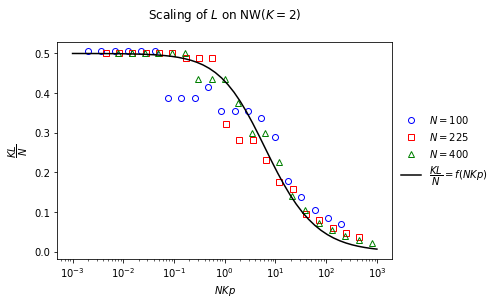

In [10]:
def breadth_first_search(G):
    dists = np.full((len(G),len(G)),-1,int)
    np.fill_diagonal(dists,0)
    for i in G:
        read,visited = 0,[i]
        while read < len(visited):
            u,read = visited[read],read+1
            d = dists[i,u]
            for v in G[u]:
                if dists[i,v] < 0:
                    dists[i,v] = d+1
                    visited += [v]
    return dists
# breadth-first search (BFS): O(N*(N+E))
# Floyd-Warshall (FW):        O(N^3)

Ns,K = [100,225,400],2
ps = np.logspace(-5,0,20)
for i,N in enumerate(Ns):
    plt.plot(ps*N*K, [K/N*breadth_first_search(nw(N,K,p,5056)).sum()/(N*(N-1))
                      for p in ps], ['bo','rs','g^'][i], mfc='none', label='$N=%d$'%N)
xs = np.logspace(-3,3)
plt.plot(xs, f(xs), 'k', label=r'$\dfrac{KL}{N}=f\left(NKp\right)$')
plt.legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
plt.title(r'Scaling of $L$ on $\mathrm{NW}\left(K=2\right)$'+'\n')
plt.xlabel('$NKp$')
plt.ylabel('$\dfrac{KL}{N}$')
plt.xscale('log')
plt.show()

## 2.3 Mathematics of the clustered small world

Let us consider the scaling function $f{\left(x\right)}$ again. Since $x\gg1$ leads to $f{\left(x\right)} \rightarrow \dfrac{\ln{x}}{x}$, $L = \dfrac{\ln{\left(NKp\right)}}{K^2p}$ if $NKp\gg1$. Recall that $NKp$ is twice the number of shortcuts; the condition $NKp\gg1$ thus generally means that the small-world effect $L\sim\ln{N}$ emerges in a network as long as we add sufficient shortcuts. If $N\rightarrow\infty$, even a tiny $p$ can result in $NKp\gg1$, implying that an enormous network just needs a very low density of shortcuts in order to become a small world. At the same time, as we have seen, the netowork's transitivity $T$ is high when $p\rightarrow0^+$, so it is highly clustered. After all, the NW model helps us understand a clustered smalled world mathematically better.

---
# 3. Small-World Routing

Although they physically and mathematically explain our clustered small world, the Watts-Strogatz model and the Newman-Watts model do not truly explain the impressive results of Milgram's small-world experiment. The participants of the experiment could deliver their letters successfully not just because the world was small. Another crucial reason was that with before sending ther letters, the participants could rationally guess which of their friends were closer to their targets, and this allowed the letters to get progressively closer to their targets. Overall,

**<p style="text-align: center">while a small world does have short distances between nodes,</p>**
**<p style="text-align: center">not every small world favours an efficient routing of information among nodes.</p>**

Do not forget that a random network is also a small world—do you expect an efficent delivery of information on a small but **messy** world?

## 3.1 Reproducing the small-world experiment

Kleinberg numerically reproduced the small-world experiment [8]. He considered an $n\times n$ periodic square lattice, whose nodes represent the  $N=n^2$ participants of the experiment. In each trial, a source node $s$ tries to deliver information to a target node $t$ by passing it to a neighbour, who repeats this step after receiving the information. While deciding whom to pass to, a node $i$ only knows three pieces of information:

1. its own coordinates $\left(x_i,y_i\right)$,
2. its neighbours' coordinates $\left(x_j,y_j\right)$, and
3. its targets's coordinates $\left(x_t,y_t\right)$.

Based on such local information, $i$ takes a greedy move and passes its information to the neighbour $j$ who is the closest to $t$. Kleinberg called the routing process a decentralized search because only local information is available to participants.  He measured the average delivery time $T$, i.e. the expected steps for $s$'s message to reach $t$. 

On a periodic square lattice, $T\equiv L\times\dfrac{1\text{ step}}{1\text{ edge}}$ and simply scales with $\sqrt{N}=n$.

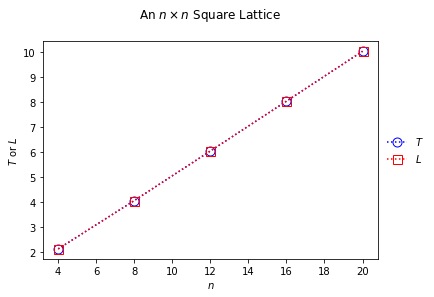

In [11]:
def dist_grid(c1, c2, n):
    (x1,y1),(x2,y2) = c1,c2
    dx,dy = abs(x1-x2),abs(y1-y2)
    dx = n-dx if dx>n/2 else dx
    dy = n-dy if dy>n/2 else dy
    return dx+dy

def delivery_time(G, s, t, n):
    if s == t: return 0
    ds = [dist_grid(G.nodes[nbr]['coord'], G.nodes[t]['coord'], n) for nbr in G[s]]
    return delivery_time(G, list(G[s])[np.argmin(ds)], t, n)+1

relabel = nx.convert_node_labels_to_integers
square = lambda n: relabel(nx.grid_2d_graph(n,n,True), label_attribute='coord')
ns = [4,8,12,16,20]
Ts = [sum(delivery_time(square(n),0,t,n) for t in range(1,n**2))/(n**2-1) for n in ns]
Ls = [breadth_first_search(square(n)).sum()/(n**2*(n**2-1)) for n in ns]

plt.plot(ns, Ts, 'bo:', mfc='none', ms=9, label='$T$')
plt.plot(ns, Ls, 'rs:', mfc='none', ms=9, label='$L$')
plt.legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
plt.title(r'An $n\times n$ Square Lattice'+'\n')
plt.xlabel('$n$')
plt.ylabel('$T$ or $L$')
plt.show()

## 3.2. Failure of the Watt-Strogatz model

Kleinberg first carried out the simulation on a variant of the WS model (temporarily I will call it the "KWS" model). Instead of a regular ring, the KWS model started with an $n\times n$ periodic square lattice. Kleinberg then added $K\ll N$ directed shortcuts $\left(i\rightarrow j\right)$ to every node $i$, where $j$ is uniformly chosen at random. (This formulation in fact resembles the NW model more because they both create shortcuts by adding edges.)

While Kleinberg did not discuss the possibility of self-loops and multi-edges, I propose to ban self-loops but not multi-edges for some practical problems that we will see. In other words, the model selects $j$ from all nodes but $i$ when adding a shortcut $\left(i,j\right)$. Still, multi-edges do not contribute to the small-world experiment.

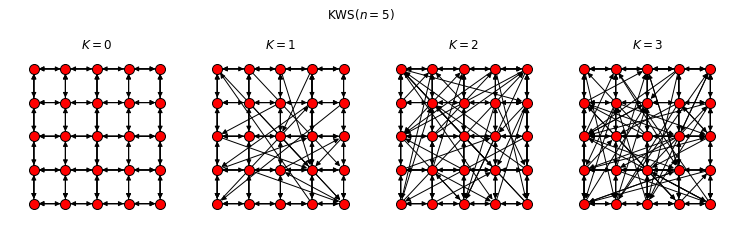

In [13]:
def kleinberg(n, K=1, seed=None):
    base = relabel(nx.grid_2d_graph(n,n,True,nx.DiGraph), label_attribute='coord')
    base.graph['pos'] = nx.get_node_attributes(base, 'coord')
    if K == 0: return base
    
    np.random.seed(seed)
    ps = np.full((n*n,n*n), 1/(n*n-1))
    np.fill_diagonal(ps, 0)
    for i in base:
        js = np.random.choice(n*n, K, False, ps[i])
        base.add_edges_from([(i,j) for j in js])
    return nx.DiGraph(base)

n = 5
pos = kleinberg(n,0).graph['pos']
fig,ax = plt.subplots(1,4, figsize=(3*4+.2*3,3))
fig.suptitle(r'$\mathrm{KWS}{\left(n=%d\right)}$'%n, y=1.1)
for K,a in enumerate(ax):
    a.set_title(r'$K=%d$' % K)
    nx.draw(kleinberg(n, K, 5056+K), pos, a, node_size=100, edgecolors='k')

Although the resultant KWS networks posses the small-world property, i.e. $L\sim\ln{N}\sim\ln{n}$, Kleinberg observed that $T$ on them does not follow the same logarithmic trend. Instead, he proved that the lower bound of $T$ scales with $n^{2/3}$, i.e. $\ln{\left(\inf{\{T\}}\right)}\sim\dfrac{2}{3}\ln{n}$ with the infimum running over all possible KWS networks for a fixed configuration [9]. This observation ultimately implies that if the WS model indeed described our world, Milgram's small-world experiment would never be able to reveal how small our world is.

T ~ n ^ 0.787


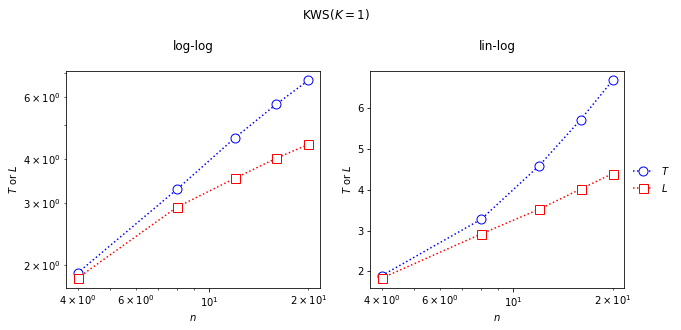

In [14]:
ns = [4,8,12,16,20]
Ts,Ls = [],[]
for n in ns:
    N = n**2
    kws = kleinberg(n, 1, 5056+n)
    Ts += [sum(delivery_time(kws,s,t,n)
               for s in range(N) for t in range(N) if s<t)/(N*(N-1)/2)]
    Ls += [breadth_first_search(kws).sum()/(N*(N-1))]

fig,ax = plt.subplots(1,2, figsize=(10,4))
for a in ax:
    a.loglog(ns, Ts, 'bo:', mfc='w', ms=9, label='$T$')
    a.loglog(ns, Ls, 'rs:', mfc='w', ms=9, label='$L$')
a.set_yscale('linear')
a.legend(loc='center left', bbox_to_anchor=(1,.5), frameon=False)
for i,a in enumerate(ax):
    a.set_xlabel('$n$')
    a.set_ylabel('$T$ or $L$')
    a.set_title(('lin' if i else 'log')+'-log\n')
fig.suptitle(r'$\mathrm{KWS}{\left(K=1\right)}$', y=1.1)
    
print('T ~ n ^ %.3g' % np.polyfit(np.log(ns), np.log(Ts), 1)[0])

## 3.3. The Kleinberg model

Kleinberg attributed the deviation to the uniformly random shortcuts on WS networks - **shortcuts in our world are certianly not uniformly random but biased to factors** like people's similar traits or short geographical separation. Therefore, Kleinberg developed the Kleinberg model, which features **biased shortcuts**: 

1. Same as the KWS model, the Kleinberg model starts with an $n\times n$ periodic square lattice
2. $K$ directed shortcuts are inserted to each node $i$. Different from KWS model, a shortcuts $\left(i\rightarrow j\right)$ is added according to the probability $p=d_{ij}^{-q}$ [8], where $d_{ij}$ represents the distance between $i$ and $j$ on the lattice. 

As a result, shorter shortcuts are favoured during the process. Kleinberg called $q$ as the clustering exponent, and the KWS model is just a special case of the Kleinberg model with $q=0$.

Because $d_{ii}=0$, self-loops would be definitely realized if they were allowed, so I propose to ban them. On the other hand, the existence of multi-edges smoothly reduces a Kleinberg network to an ordinary square lattice as $q\rightarrow\infty$.

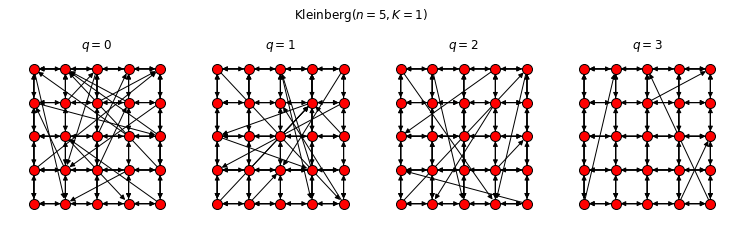

In [15]:
def kleinberg(n, q, K=1, seed=None):
    base = relabel(nx.grid_2d_graph(n,n,True,nx.DiGraph), label_attribute='coord')
    base.graph['pos'] = nx.get_node_attributes(base, 'coord')
    if K == 0: return base
    
    np.random.seed(seed)
    ps = np.array([[dist_grid(base.nodes[i]['coord'], base.nodes[j]['coord'], n) for i in range(n*n)] for j in range(n*n)], float)
    np.fill_diagonal(ps, 1); ps = ps**-q
    np.fill_diagonal(ps, 0); ps /= ps.sum(1).reshape(-1,1)
    for i in base:
        js = np.random.choice(n*n, K, False, ps[i])
        base.add_edges_from([(i,j) for j in js])
    return nx.DiGraph(base)

n,K = 5,1
fig,ax = plt.subplots(1,4, figsize=(3*4+.2*3,3))
fig.suptitle(r'$\mathrm{Kleinberg}{\left(n=%d,K=%d\right)}$'%(n,K), y=1.1)
for i,a in enumerate(ax):
    a.set_title(r'$q=%.2g$' % i)
    nx.draw(kleinberg(n, i, K, 5056+i), pos, a, node_size=100, edgecolors='k')

Kleinberg analyzed that as $n\rightarrow\infty$, the clustering exponent $q$ crucially determined the participants' performance [10]: with $\inf{\{T\}} \sim n^\beta$,

\begin{align*} \beta =
    \begin{cases}
        \dfrac{2-q}{3}   & \left(q<2\right) \\
        \dfrac{q-2}{q-1} & \left(q>2\right)
    \end{cases}\,.
\end{align*}

Particularly at $q=2$, $\beta$ shrinks to its optimum $\beta=0$; at the same time, $T$ scales with $\dfrac{1}{K}\ln^2{N}$, so the order of $T$ will be restored to that of $L$, i.e. $T\sim\ln{N}$ once the number of shortcuts per node $K\sim\ln{N}$.

This analysis, however, can hardly be numerically verified because it is only valid at an enormous $n$, which requires a very intensive simulation (at least too intensive for this tutorial's demonstration). If $n$ is not large enough, the behaviour of $\beta$ deviates much from the prediction. Kleinberg actually tested his theory against $1000$ trials on $n=20000$, yet the optimal $\beta$ he obtained still deviated from $q=2$ but saturated around $q=1.8$.

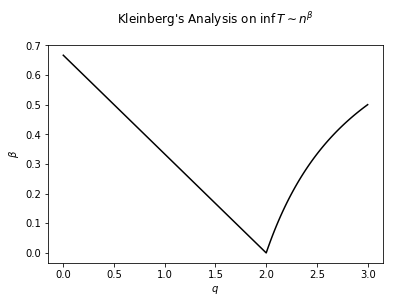

In [16]:
qs = np.concatenate((np.linspace(0,2),np.linspace(2,3)))
beta = np.frompyfunc(lambda q: (2-q)/3 if q<2 else 1-1/(q-1),1,1)
plt.plot(qs, beta(qs), 'k-')
plt.title('Kleinberg\'s Analysis on %s \n' % r'$\inf{\,T}\sim n^\beta$')
plt.xlabel('$q$')
plt.ylabel(r'$\beta$')
plt.show()

## 3.4. The critical clustering exponent

Kleinberg's analysis raises an interesting question: why is $q=2$ special? Kleinberg argued this criticality with the following intuition [10]. Given that $n\gg1$, a source $s$ on an $n\times n$ square lattice has roughly $N_d\sim d^2$ neighbours $d$ steps away, so around $N_dd^{-q}\sim d^{2-q}$ nodes will become $s$'s neighbours via shortcuts. Now $s$ wants to send some information to a target $t$.

- If $q>2$, $d^{2-q}$ decreases with $d$. Long-range shortcuts a great $d$ are thus rare, while most of $s$'s shortcuts stay inside its vicinity. The information of $s$ is therefore trapped and can only reach $t$ by slowly traversing multiple short-range edges.

- If $q<2$, $d^{2-q}$ increases with $d$, so long-range shortcuts are abundant yet too long. The information of $s$ quickly reaches the vicinity of  $t$, but then it inevitably wastes much time travelling to $t$ via the short-range edges around it. The shortcuts near $t$ are often so long that they cannot help route the information to $t$ but somewhere far away. 

- At $q=2$, $d^{2-q}=1$ remains constant. Hence $s$ always posseses a shortcut to a node who was originally $d$ steps away. The information of $s$ can therefore, regardless of its distance to $t$, always utilize some shortcut and save some time of routing.

One may in fact generalize the Kleinberg model by initializing the network with a $D$-dimensional lattice, and this paragraph's arguments still hold for $q=D$. After all, Kleinberg's analysis helps us interpret the impressive results of Milgran's small-world experiment better: while our world is highly clustered and small, it is never arbitrarily formed but meaningfully structured.

# References

1. Milgram S.: The Small World Problem. Psychology Today 2, 60–67 (1967).
2. Watts D. J., Strogatz S. H.: Collective dynamics of 'small-world' networks. Nature 393(6684), 440–442 (1998).
3. Barrat A., Weigt M.: On the properties of small-world network models. Eur. Phys. J. B. 13(3), 547–560 (2000).
4. Newman M. E. J.: Networks: An Introduction. Oxford University Press, Oxford (2010).
4. Newman M. E. J., Watts, D. J.: Scaling and percolation in the small-world network model. Phys. Rev. E 60(6), 7332–7342 (1999).
5. Barthélémy M., Amaral L. A. N.: Small-World Networks: Evidence for a Crossover Picture. Phys. Rev. Lett. 82(15), 3180–3183 (1999).
6. Newman M. E. J., Moore C., Watts D. J.: Mean-Field Solution of the Small-World Network Model. Phys. Rev. Lett. 84(14), 3201–3204 (2000).
7. Kleinberg J.: Navigation in a small world. Nature 406, 845 (2000).
8. Kleinberg J.: The small-world phenomenon: An algorithmic perspective. Proc. of the 32nd Annu. ACM Symp. Theory Comput., 163–170 (2000).
9. Easley D., Kleinberg J.: Networks, Crowds, and Markets: Reasoning about a Highly Connected World. Cambridge University Press, Cambridge (2010).